This notebook builds a high-resolution visualization of the inverter and battery-module thermistor data from the Western Formula Racing electric vehicle, queried directly from InfluxDB 3. It highlights advanced time-series processing and multi-axis visualization techniques for engineering telemetry.

In [8]:
import os
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from tabulate import tabulate
from influxdb_client_3 import InfluxDBClient3

client = InfluxDBClient3(
    host=os.getenv("INFLUX_SERVER"),
    token=os.getenv("INFLUX_TOKEN"),
    database="WFR25"
)

In [9]:
# Check InfluxDB connection
try:
    # Simple query to test connection
    test_query = client.query("SELECT 1 as test")
    print("Connection to InfluxDB successful!")
    print("Test query result:", test_query)
except Exception as e:
    print(f"Connection failed: {e}")

Connection to InfluxDB successful!
Test query result: pyarrow.Table
test: int64 not null
----
test: [[1]]


Plot window (Toronto local): 2025-06-20 17:58:00-04:00 → 2025-06-20 18:02:00-04:00
Converted to UTC: 2025-06-20 21:58:00+00:00 → 2025-06-20 22:02:00+00:00
Running composite plot query...


/tmp/ipykernel_315546/1434857575.py:197: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


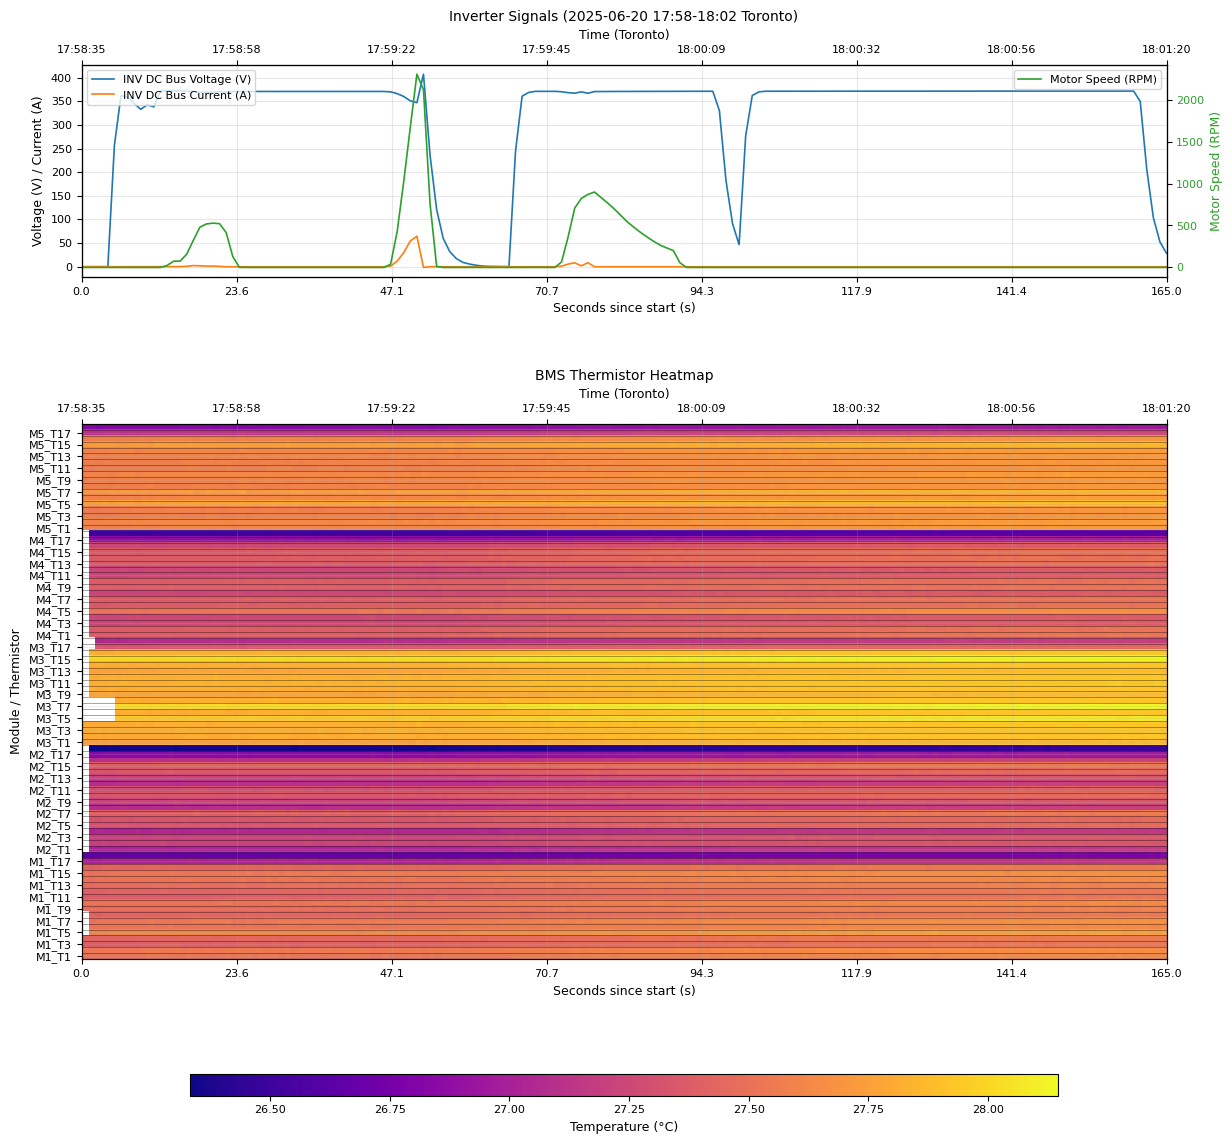

In [10]:
# Complex Plot: Inverter & BMS Detailed Thermistor Visualization

# User input
START_HHMM = "17:58"   # local Toronto time start
END_HHMM   = "18:02"   # local Toronto time end
REPORT_DATE = "2025-06-20"
DATABASE = "WFR25"     # adjust if needed

# Convert local hh:mm to UTC timezone
toronto_tz = ZoneInfo("America/Toronto")
date_base = datetime.strptime(REPORT_DATE, "%Y-%m-%d").replace(tzinfo=toronto_tz)
start_local = date_base.replace(
    hour=int(START_HHMM.split(":")[0]),
    minute=int(START_HHMM.split(":")[1])
)
end_local = date_base.replace(
    hour=int(END_HHMM.split(":")[0]),
    minute=int(END_HHMM.split(":")[1])
)
start_utc = start_local.astimezone(ZoneInfo("UTC"))
end_utc = end_local.astimezone(ZoneInfo("UTC"))
print(f"Plot window (Toronto local): {start_local} → {end_local}")
print(f"Converted to UTC: {start_utc} → {end_utc}")

# Query (requesting data)
query = f"""
SELECT "time", "sensorReading", "signalName"
FROM "iox"."{DATABASE}"
WHERE "time" >= TIMESTAMP '{start_utc.isoformat()}'
  AND "time" < TIMESTAMP '{end_utc.isoformat()}'
  AND (
    "signalName" IN (
      'INV_DC_Bus_Voltage',
      'INV_DC_Bus_Current',
      'INV_Motor_Speed'
    )
    OR "signalName" LIKE 'M%_Thermistor%'
  )
ORDER BY "time" ASC
"""
# Human language version of this query:
"""
From the InfluxDB database WFR25, between the UTC times X and Y,
return all rows where the signal name is one of the inverter signals
(voltage, current, motor speed) or matches any BMS thermistor channel, sorted by time.
"""

print("Running composite plot query...")
result = client.query(query)
df = result.to_pandas()

if df.empty:
    raise ValueError("No data found for selected range.")

df["time"] = pd.to_datetime(df["time"])
df["time_s"] = df["time"].dt.floor("1s")

# Separate INV and thermistor data
analog_df = df[df["signalName"].isin(["INV_DC_Bus_Voltage", "INV_DC_Bus_Current", "INV_Motor_Speed"])].copy()
thermal_df = df[df["signalName"].str.match(r"M\d+_Thermistor\d+", case=False, na=False)].copy()

if thermal_df.empty:
    raise ValueError("No BMS thermistor data found (expected pattern like 'M3_Thermistor5').")

thermal_df = thermal_df.dropna(subset=["signalName"]).copy()
thermal_df["module"] = thermal_df["signalName"].str.extract(r"M(\d+)_")[0].astype(int)
thermal_df["thermistor"] = thermal_df["signalName"].str.extract(r"Thermistor(\d+)")[0].astype(int)
thermal_df["row_index"] = thermal_df["module"] * 100 + thermal_df["thermistor"]

# 1s mean per thermistor
thermal_avg = (
    thermal_df.groupby(["time_s", "row_index"])["sensorReading"]
    .mean()
    .reset_index()
    .pivot(index="time_s", columns="row_index", values="sensorReading")
    .sort_index()
)
thermal_avg = thermal_avg.resample("1s").mean().interpolate()

# Pivot INV table and 1s mean
analog_pivot = (
    analog_df.pivot_table(index="time_s", columns="signalName", values="sensorReading", aggfunc="mean")
    .sort_index()
    .resample("1s").mean().interpolate()
)

# Determine common time range for plot x-axis range
all_times = pd.Index(thermal_avg.index).union(analog_pivot.index)
t_min = (all_times.min() - all_times.min()).total_seconds()
t_max = (all_times.max() - all_times.min()).total_seconds()

# 2 subplots
thermal_height = max(4, 0.12 * len(thermal_avg.columns))
analog_height = 3  # fixed height for analog plot
total_height = thermal_height + analog_height + 0.8

fig = plt.figure(figsize=(14, total_height))
gs = fig.add_gridspec(2, 1, height_ratios=[analog_height, thermal_height], hspace=0.3)

# Top plot: INV signals
ax_analog = fig.add_subplot(gs[0])
ax_analog.set_title(f"Inverter Signals ({REPORT_DATE} {START_HHMM}-{END_HHMM} Toronto)", fontsize=10)

t = (analog_pivot.index - all_times.min()).total_seconds()

# Left axis: Voltage + Current
if "INV_DC_Bus_Voltage" in analog_pivot:
    ax_analog.plot(t, analog_pivot["INV_DC_Bus_Voltage"], color="tab:blue", label="INV DC Bus Voltage (V)", linewidth=1.2)
if "INV_DC_Bus_Current" in analog_pivot:
    ax_analog.plot(t, analog_pivot["INV_DC_Bus_Current"], color="tab:orange", label="INV DC Bus Current (A)", linewidth=1.2)

ax_analog.set_xlim(t_min, t_max)
ax_analog.set_ylabel("Voltage (V) / Current (A)", fontsize=9)
ax_analog.set_xlabel("Seconds since start (s)", fontsize=9)
ax_analog.legend(loc="upper left", fontsize=8)
ax_analog.grid(alpha=0.3)
ax_analog.tick_params(labelsize=8)

# Right axis: Motor Speed
ax_speed = ax_analog.twinx()
if "INV_Motor_Speed" in analog_pivot:
    ax_speed.plot(t, analog_pivot["INV_Motor_Speed"], color="tab:green", label="Motor Speed (RPM)", linewidth=1.2)
    ax_speed.set_ylabel("Motor Speed (RPM)", color="tab:green", fontsize=9)
    ax_speed.tick_params(axis="y", labelcolor="tab:green", labelsize=8)
    ax_speed.legend(loc="upper right", fontsize=8)

# Add secondary x-axis for Toronto time on analog plot
ax_analog_time = ax_analog.twiny()
ax_analog_time.set_xlim(ax_analog.get_xlim())
start_time_utc = all_times.min().tz_localize(ZoneInfo("UTC"))
num_ticks = 8
tick_positions = np.linspace(t_min, t_max, num_ticks)
ax_analog.set_xticks(tick_positions)
ax_analog_time.set_xticks(tick_positions)
toronto_times = [start_time_utc + timedelta(seconds=s) for s in tick_positions]
toronto_times_local = [t.tz_convert(toronto_tz) for t in toronto_times]
ax_analog_time.set_xticklabels([t.strftime('%H:%M:%S') for t in toronto_times_local], fontsize=8)
ax_analog_time.set_xlabel("Time (Toronto)", fontsize=9)

# Bottom plot: heatmap
ax_thermal = fig.add_subplot(gs[1])
ax_thermal.set_title(f"BMS Thermistor Heatmap", fontsize=10)

times_num = (thermal_avg.index - all_times.min()).total_seconds().values
extent = [t_min, t_max, 0.5, len(thermal_avg.columns) + 0.5]
im = ax_thermal.imshow(
    thermal_avg.T,
    aspect="auto",
    cmap="plasma",
    extent=extent,
    origin="lower",
    interpolation="none",
    norm=Normalize(vmin=thermal_avg.min().min(), vmax=thermal_avg.max().max())
)

# Color bar on bottom to avoid x-axis shrinking
cbar = plt.colorbar(im, ax=ax_thermal, orientation='horizontal', pad=0.15, aspect=40, shrink=0.8)
cbar.set_label("Temperature (°C)", fontsize=9)
cbar.ax.tick_params(labelsize=8)

# Show every other thermistor label to reduce clutter
show_every = 2
yticks = np.arange(1, len(thermal_avg.columns) + 1)
yticklabels = [f"M{col//100}_T{col%100}" for col in thermal_avg.columns]

ax_thermal.set_yticks(yticks[::show_every])
ax_thermal.set_yticklabels(yticklabels[::show_every], fontsize=5)

ax_thermal.set_ylabel("Module / Thermistor", fontsize=9)
ax_thermal.set_xlabel("Seconds since start (s)", fontsize=9)
ax_thermal.tick_params(labelsize=8)

ax_thermal.set_xlim(t_min, t_max)
ax_thermal.set_xticks(tick_positions)

modules = sorted(set(col // 100 for col in thermal_avg.columns))
for m in modules[1:]:
    idx = sum(thermal_avg.columns // 100 < m)
    ax_thermal.axhline(idx + 0.5, color="white", lw=0.3, alpha=0.5)

# Add very thin separator lines between each swim lane
for y in np.arange(1.5, len(thermal_avg.columns) + 0.5, 1):
    ax_thermal.axhline(y, color="black", lw=0.5, alpha=0.5)

ax_thermal.grid(alpha=0.2)

# Secondary x-axis for local time
ax_thermal_time = ax_thermal.twiny()
ax_thermal_time.set_xlim(ax_thermal.get_xlim())
ax_thermal_time.set_xticks(tick_positions)
ax_thermal_time.set_xticklabels([t.strftime('%H:%M:%S') for t in toronto_times_local], fontsize=8)
ax_thermal_time.set_xlabel("Time (Toronto)", fontsize=9)

# Save in output
plt.savefig("output/Accumulator_Swimlane.png", dpi=300)

plt.tight_layout()
plt.show()